In [1]:
#represents the user’s environmental variables
#needed to get the X files
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

#%matplotlib inline #si figure

 # load libraries
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random
from PIL import Image

#For CNN functions
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from keras import callbacks
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
#Load the pictures

############Adjustments##############

# options
PATH = "xxx/data/"
OPTION = 'label'  # area or label (classification => label, for regression => area)
FOLDER = 'X_arrays_bw/'

## Adjustments

filename_Y_labels = 'y_array_with_binary_labels.txt'

########################

path_data_X = PATH + FOLDER  # png's
path_data_y = PATH + 'Y_arrays/'  # labels

filename = path_data_y + filename_Y_labels
y = pd.read_csv(filename, sep="\t")

filenames_X_train = []
filenames_X_test = []
directory_list = os.listdir(path_data_X)

# divide data in test and train set
i = 0
for filename in directory_list:
    if ".png" in filename:
        if i % 3 == 0:
            filenames_X_test.append(path_data_X + filename)
        else:
            filenames_X_train.append(path_data_X + filename)
        i = i + 1
        
        
def load_X_if_matched_in_y(filenames_list, y):
    all_images_as_array = []
    label = []
    area = []

    ordered_filenames_lab = pd.DataFrame()
    ordered_filenames_ar = pd.DataFrame()

    for filename in filenames_list:
        filename_wopath = filename.split(FOLDER)[1]
        filename_wopath = filename_wopath.strip(".png")

        matching_y = y[y.SampleTargetedcombination == filename_wopath] #search for a match
        if len(matching_y) == 1: # use the png if there is exact 1 match
            lab = matching_y.iloc[0, 5] #save the label found/not found
            label.append(lab)
            ar = matching_y.iloc[0, 3] #save the area
            area.append(ar)

            img = Image.open(filename)
            np_array = np.asarray(img)
            l, b = np_array.shape
            np_array = np_array.reshape(l * b , )
            all_images_as_array.append(np_array)

            file_area = pd.DataFrame(np.array([[filename_wopath, ar]])) #save the filename together with the area
            ordered_filenames_ar = ordered_filenames_ar.append(file_area, ignore_index=True)

            file_label = pd.DataFrame(np.array([[filename_wopath, lab]])) #save the filename together with the label
            ordered_filenames_lab = ordered_filenames_lab.append(file_label, ignore_index=True)


        if len(matching_y) != 1:
            continue 

   #  this is extra, to check the used files
    if OPTION == 'area':
        option = area
        df = ordered_filenames_ar
    else:
        option = label
        df = ordered_filenames_lab
    return np.array(all_images_as_array), np.array(option), df

X_train, y_train, df_train = load_X_if_matched_in_y(filenames_X_train, y)
X_test, y_test, df_test = load_X_if_matched_in_y(filenames_X_test, y)


#print(len(y_train))
#print(len(X_train))
#print(len(y_test))
#print(len(X_test))

In [3]:
# Reshape
X_train = X_train.reshape((len(X_train),64, 64,1))
X_test = X_test.reshape((len(X_test),64, 64,1)) 
    
# Normalisation
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255
X_test = X_test / 255

# Model with parameters 
#-----------------------------------------------
batch_size = 32 # 
epochs = 20 # 
#-----------------------------------------------
#-----------------------------------------------
num_classes = 2
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols,1)
#K in K-fold cross validation
K = 10

In [4]:
#checkpoint for weights improvment

checkpoint_path = "CV-model1-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path , monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#earlystopping
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 10, restore_best_weights = True) #prevents overfitting

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.32990705966949463; accuracy of 85.16483306884766%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.33739855885505676; accuracy of 87.08791136741638%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.3145192563533783; accuracy of 87.05233931541443%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.34550583362579346; accuracy of 87.05233931541443%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.3755830228328705; accuracy of 83.47107172012329%
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss of 0.22

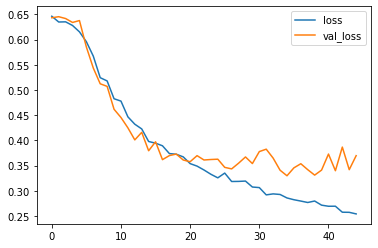

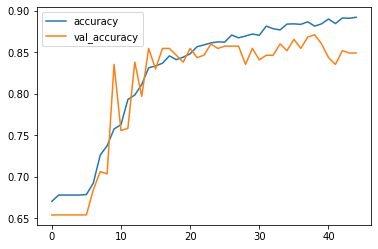

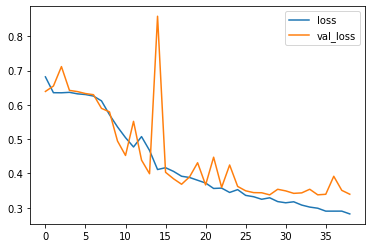

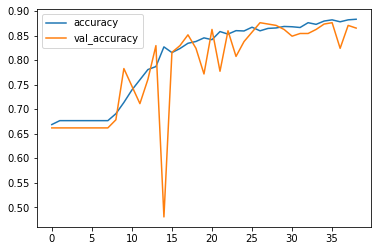

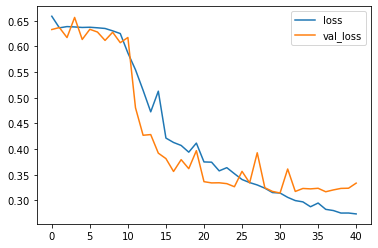

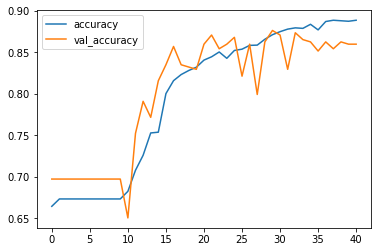

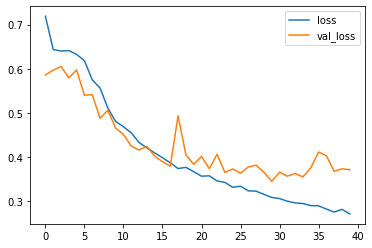

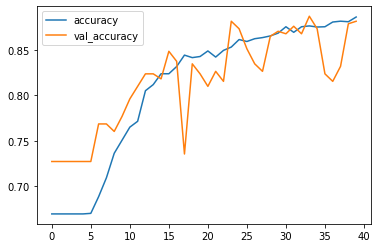

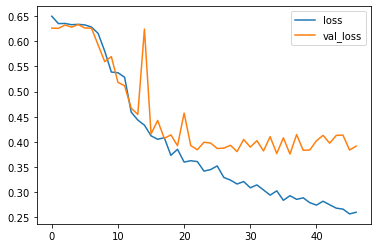

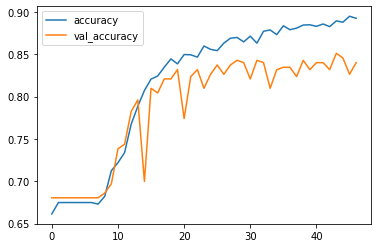

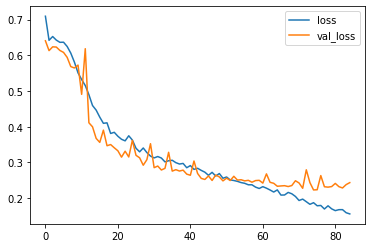

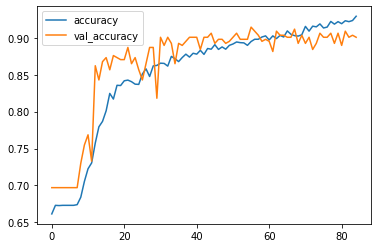

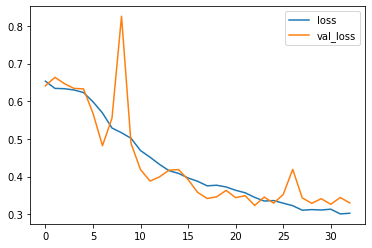

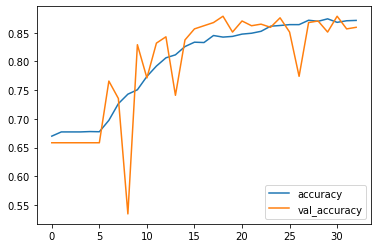

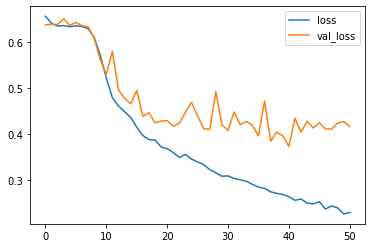

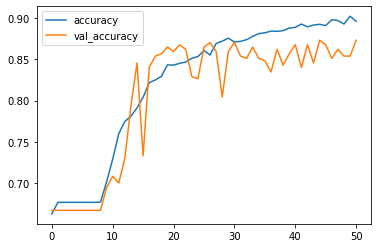

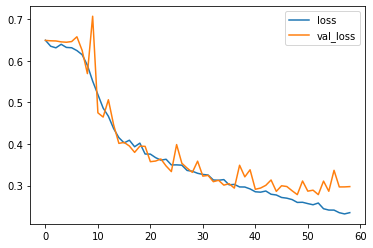

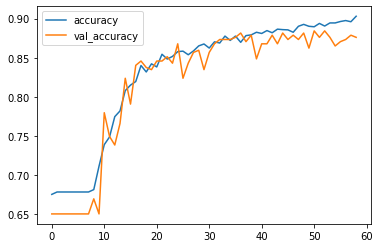

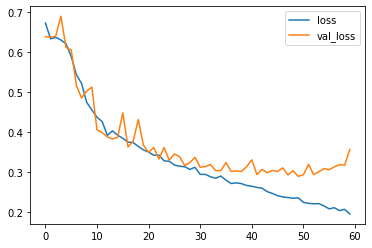

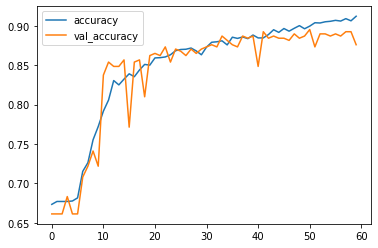

In [5]:
from sklearn.model_selection import KFold
#import numpy as np

acc_per_fold = []
loss_per_fold = []

num_folds = K

# Merge inputs and targets
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    # Define the model architecture
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X[train], y[train],
              batch_size=100,
              epochs=120,
              verbose=0,
              validation_data=(X[test],y[test]),
              callbacks = [earlystopping]) #can add callcack

  # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    metrics_df = pd.DataFrame(history.history)
    metrics_df[["loss","val_loss"]].plot();
    metrics_df[["accuracy","val_accuracy"]].plot();



In [6]:
len(test)

363

In [7]:
len(train)

3269

In [8]:
checkpoint_path2 = "CV-model2-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path2)
cp_callback2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path2 , monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
# K-fold Cross Validation model 2 evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    # Define the model architecture
    model2 = Sequential()
    model2.add(Conv2D(15, (3, 3), input_shape=input_shape, activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    model2.add(Conv2D(20, (5, 5), activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2, 2)))
    model2.add(Dropout(0.3))
    model2.add(Flatten())
    model2.add(Dense(64, activation='relu'))
    model2.add(Dense(20, activation='relu'))
    model2.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history2 = model2.fit(X[train], y[train],
              batch_size=100,
              epochs=120,
              verbose=0,
              validation_data=(X[test],y[test]),
              callbacks = [earlystopping]) #can add callcack

  # Generate generalization metrics
    scores = model2.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model2.metrics_names[0]} of {scores[0]}; {model2.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no = fold_no + 1
    
    metrics_df = pd.DataFrame(history2.history)
    metrics_df[["loss","val_loss"]].plot();
    metrics_df[["accuracy","val_accuracy"]].plot();

------------------------------------------------------------------------
Training for fold 1 ...


In [ ]:
checkpoint_path3 = "CV-model3-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path3)
cp_callback3 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path3 , monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [ ]:
#### K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    # Define the model architecture
    model3 = Sequential()
    model3.add(Conv2D(10, (3, 3), input_shape=input_shape, activation='relu'))
    model3.add(MaxPooling2D(pool_size=(2, 2)))
    model3.add(Conv2D(20, (3, 3), activation='relu'))
    model3.add(MaxPooling2D(pool_size=(2, 2)))
    model3.add(Dropout(0.3))
    model3.add(Conv2D(15, (3, 3), activation='relu'))
    model3.add(MaxPooling2D(pool_size=(2, 2)))
    model3.add(Dropout(0.2))
    model3.add(Flatten())
    model3.add(Dense(128, activation='relu'))
    model3.add(Dense(50, activation='relu'))
    model3.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    model3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history3 = model3.fit(X[train], y[train],
              batch_size=100,
              epochs=120,
              verbose=0,
              validation_data=(X[test],y[test]),
              callbacks = [earlystopping]) #can add callcack

    
  # Generate generalization metrics
    scores = model3.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model3.metrics_names[0]} of {scores[0]}; {model3.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    metrics_df = pd.DataFrame(history3.history)
    metrics_df[["loss","val_loss"]].plot();
    metrics_df[["accuracy","val_accuracy"]].plot();